In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the dataset
df = pd.read_csv('/content/heart.csv')

In [5]:
# Inspect the dataset
print("Dataset Overview:")
print(df.head())
print(df.info())
print(df.describe())

Dataset Overview:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 no

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64



Target Distribution:
target
1    526
0    499
Name: count, dtype: int64


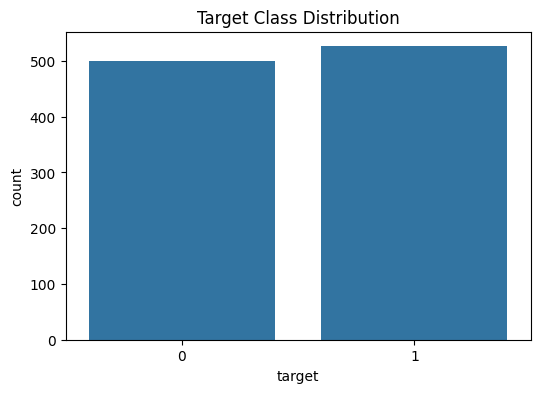

In [7]:
# Data analysis
print("\nTarget Distribution:")
print(df['target'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='target')
plt.title('Target Class Distribution')
plt.show()


Correlation Heatmap:


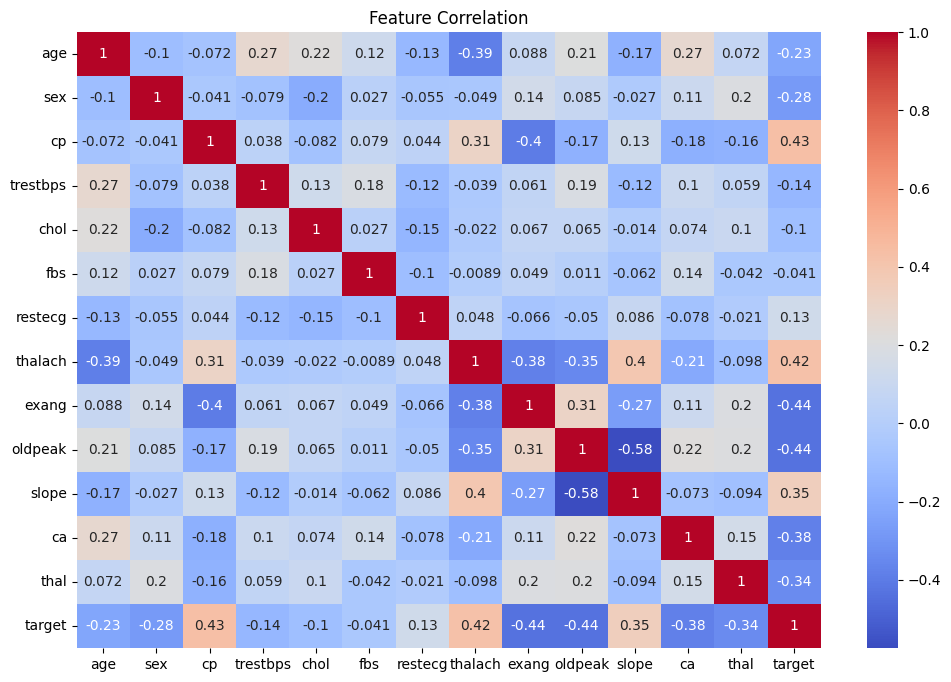

In [8]:
print("\nCorrelation Heatmap:")
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

In [9]:
# Data preprocessing
X = df.drop(columns=['target']).values
y = df['target'].values

In [10]:
# Normalize features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [11]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [12]:
# Dataset class
class HeartDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [13]:
# Create dataset object
dataset = HeartDataset(X_tensor, y_tensor)

In [14]:
# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [15]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(hidden_layers)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_layers[i]))
            else:
                layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(activation_fn())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [16]:
# Training function
def train_and_evaluate(model, train_loader, test_loader, epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [17]:
# Hyperparameters to compare
hidden_layers_options = [[4], [8], [16], [32, 16], [64, 32, 16]]
activation_functions = {'relu': nn.ReLU, 'sigmoid': nn.Sigmoid, 'tanh': nn.Tanh, 'linear': nn.Identity}
epochs_options = [1, 10, 25, 50, 100, 250]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128, 256, 512]

In [18]:
# Experiment 1: Hidden Layers
results_hidden_layers = []
for hidden_layers in hidden_layers_options:
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = MLP(input_size=X.shape[1], hidden_layers=hidden_layers, activation_fn=nn.ReLU)
    accuracy = train_and_evaluate(model, train_loader, test_loader, epochs=50, lr=0.01)

    results_hidden_layers.append({'hidden_layers': hidden_layers, 'accuracy': accuracy})

print("\nExperiment 1: Hidden Layers")
print(pd.DataFrame(results_hidden_layers))


Experiment 1: Hidden Layers
  hidden_layers    accuracy
0           [4]   89.268293
1           [8]   94.146341
2          [16]  100.000000
3      [32, 16]  100.000000
4  [64, 32, 16]  100.000000


In [19]:
# Experiment 2: Activation Functions
results_activation_functions = []
for activation_name, activation_fn in activation_functions.items():
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = MLP(input_size=X.shape[1], hidden_layers=[32], activation_fn=activation_fn)
    accuracy = train_and_evaluate(model, train_loader, test_loader, epochs=50, lr=0.01)

    results_activation_functions.append({'activation': activation_name, 'accuracy': accuracy})

print("\nExperiment 2: Activation Functions")
print(pd.DataFrame(results_activation_functions))


Experiment 2: Activation Functions
  activation    accuracy
0       relu  100.000000
1    sigmoid   98.536585
2       tanh  100.000000
3     linear   84.878049


In [20]:
# Experiment 3: Epochs
results_epochs = []
for epochs in epochs_options:
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = MLP(input_size=X.shape[1], hidden_layers=[32], activation_fn=nn.ReLU)
    accuracy = train_and_evaluate(model, train_loader, test_loader, epochs=epochs, lr=0.01)

    results_epochs.append({'epochs': epochs, 'accuracy': accuracy})

print("\nExperiment 3: Epochs")
print(pd.DataFrame(results_epochs))


Experiment 3: Epochs
   epochs    accuracy
0       1   82.439024
1      10   93.170732
2      25   98.048780
3      50  100.000000
4     100  100.000000
5     250  100.000000


In [21]:
# Experiment 4: Learning Rates
results_learning_rates = []
for lr in learning_rates:
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = MLP(input_size=X.shape[1], hidden_layers=[32], activation_fn=nn.ReLU)
    accuracy = train_and_evaluate(model, train_loader, test_loader, epochs=50, lr=lr)

    results_learning_rates.append({'learning_rate': lr, 'accuracy': accuracy})

print("\nExperiment 4: Learning Rates")
print(pd.DataFrame(results_learning_rates))


Experiment 4: Learning Rates
   learning_rate    accuracy
0        10.0000   77.073171
1         1.0000   65.853659
2         0.1000  100.000000
3         0.0100  100.000000
4         0.0010   92.682927
5         0.0001   82.439024


In [22]:
# Experiment 5: Batch Sizes
results_batch_sizes = []
for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = MLP(input_size=X.shape[1], hidden_layers=[32], activation_fn=nn.ReLU)
    accuracy = train_and_evaluate(model, train_loader, test_loader, epochs=50, lr=0.01)

    results_batch_sizes.append({'batch_size': batch_size, 'accuracy': accuracy})

print("\nExperiment 5: Batch Sizes")
print(pd.DataFrame(results_batch_sizes))



Experiment 5: Batch Sizes
   batch_size    accuracy
0          16  100.000000
1          32  100.000000
2          64  100.000000
3         128   98.048780
4         256   97.073171
5         512   95.609756
